In [1]:
## Visualisation for Multivariate Quantile BDLSTM (BTC/ETH)
## by Jimmy Cheung

In [2]:
## No need to carry out multiple (30) experiments and calculate RMSE, MAE, MAPE here

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt   
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [4]:
# wraps dataset into tensor -> appropriate for pytorch -> DataLoader
class Time_Series_Dataset(Dataset):
	def __init__(self, inputs, outputs):
		self.inputs = inputs
		self.outputs = outputs

	def __len__(self):
		return len(self.inputs)

	def __getitem__(self, idx):
		x = self.inputs[idx]
		y = self.outputs[idx]
		return (torch.tensor(x, dtype = torch.float32), 
			torch.tensor(y, dtype = torch.float32))

In [5]:
# DEFINITION: Quantile Bi-Directional Long-Short Term Memory model (QBDLSTM)
# This defined structure is able to handle multiple hidden layers
class BDLSTM_Quantile(torch.nn.Module):
	def __init__(self, input_size, hidden_size, num_layers, num_quantiles, 
		num_steps_ahead):
		super(BDLSTM_Quantile, self).__init__()
		self.hidden_size = hidden_size # e.g. [64, 32]
		self.num_layers = num_layers # e.g. len([64, 32]) = 2
		self.num_quantiles = num_quantiles # e.g. 5
		self.num_steps_ahead = num_steps_ahead # output size

		self.lstms = nn.ModuleList() # allows multiple layers

		self.lstms.append(nn.LSTM(input_size, hidden_size[0], # define 1st layer
			batch_first=True, bidirectional=True))

		# subsequent layer(s)
		for i in range(1, num_layers):
			self.lstms.append(nn.LSTM(hidden_size[i-1] * 2, hidden_size[i], 
				batch_first=True, bidirectional=True))

		# last layer: define for each quantile (5 instead of 1)
		self.fc = nn.ModuleList([nn.Linear(hidden_size[-1] * 2, 
			self.num_steps_ahead) for _ in range(num_quantiles)])

	# forward pass - involve strict shape consistencies
	def forward(self, x): # allows model to traverse to hidden layers
		for lstm in self.lstms:
			x, _ = lstm(x)
		lstm_out = x[:, -1, :]  # Use the output of the last time step
		# Compute the outputs for each quantile
		quantile_outputs = [fc(lstm_out) for fc in self.fc] # fc = fully connected
		# consider dropout for higher accuracy & lower computation cost
		output = torch.stack(quantile_outputs, dim = 2) 
		return output

In [6]:
# Multivariate data processing
def split_data(data, input_size, output_size, train_ratio, seed):
	# 1. split data into input features (X) and output (y)
	X, y = [], []
	total_size = input_size + output_size
	for i in range(len(data) - total_size + 1):
		X.append(features[i:i+input_size])
		y.append(target[i+input_size:i+total_size])
	# 2. shuffle batches and split into train/test
	X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = train_ratio, random_state = seed)
	return X_train, X_test, y_train, y_test

In [7]:
# Additional function for quantile regression - Quantile loss function 
def quantile_loss(preds, target, quantiles): 
	losses = [] # idea is the same as tilted loss
	for i, quantile in enumerate(quantiles):
		errors = targets[:, :, i] - preds[:, :, i]
		losses.append(torch.mean(torch.max((quantile - 1) * errors, 
			quantile * errors)))
	return torch.mean(torch.stack(losses))

In [8]:
def evaluate_model(model, test_dataloader, quantiles):
	model.eval() 
	y_hat, y_true = [], []

	with torch.no_grad(): # disable gradient calculation
		for x, y in test_dataloader:
			y = y.unsqueeze(-1).expand(-1, -1, len(quantiles)) 
			outputs = model(x) # forward pass
			y_hat.append(outputs)
			y_true.append(y)
	y_hat = torch.cat(y_hat, dim = 0)
	y_true = torch.cat(y_true, dim = 0)
	return y_hat, y_true

In [9]:
# DATA HANDLING

# data = 'bitcoin'
data = 'ethereum'

if data == 'bitcoin':
    df = pd.read_csv('../data/bitcoin.csv')
else:
    df = pd.read_csv('../data/ethereum.csv')

df = df.drop(columns = ['Adj Close'])
features = df[['High', 'Low', 'Open', 'Close', 'Volume']]
features = MinMaxScaler().fit_transform(features) # normalise input
target = df['Close']
target_reshaped = np.array(target).reshape(-1,1) # normalise output
scaler = MinMaxScaler(feature_range=(0,1)) 
target = scaler.fit_transform(target_reshaped).flatten()

In [10]:
quantiles = [0.05, 0.25, 0.50, 0.75, 0.95]
num_quantiles = len(quantiles) 
input_size = 6
output_size = 5
train_ratio = 0.7
seed = 5925
num_features = 5
num_epochs = 100
hidden_size = [64, 32]
num_layers = len(hidden_size)

In [11]:
X_train, X_test, y_train, y_test = split_data(df, input_size, output_size, train_ratio, seed)
train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)
# changing batch size affect model accuracy significantly
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) 
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# BDLSTM-Q
model = BDLSTM_Quantile(num_features, hidden_size, num_layers, num_quantiles, output_size)
# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    # inputs = X_train, targets = y_train
    for inputs, targets in train_dataloader: 
			
        # [size, num_steps_ahead, num_quantiles]
        targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles))
        optimizer.zero_grad()
        # Forward pass - [size, num_steps_ahead, num_quantiles]
        outputs = model(inputs)  
        loss = quantile_loss(outputs, targets, quantiles)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

pred_vals, act_vals = evaluate_model(model, test_dataloader, quantiles)
pred_vals = pred_vals.numpy()
y_test = act_vals.numpy()[:, :, 0]

results = {q: None for q in quantiles} # dictionary
for a, q in enumerate(quantiles):
    results[q] = pred_vals[:, :, a]

# Inverse transform
predicted_005 = scaler.inverse_transform(results[0.05])
predicted_025 = scaler.inverse_transform(results[0.25])
predicted_050 = scaler.inverse_transform(results[0.50])
predicted_075 = scaler.inverse_transform(results[0.75])
predicted_095 = scaler.inverse_transform(results[0.95])
actual_values = scaler.inverse_transform(y_test)

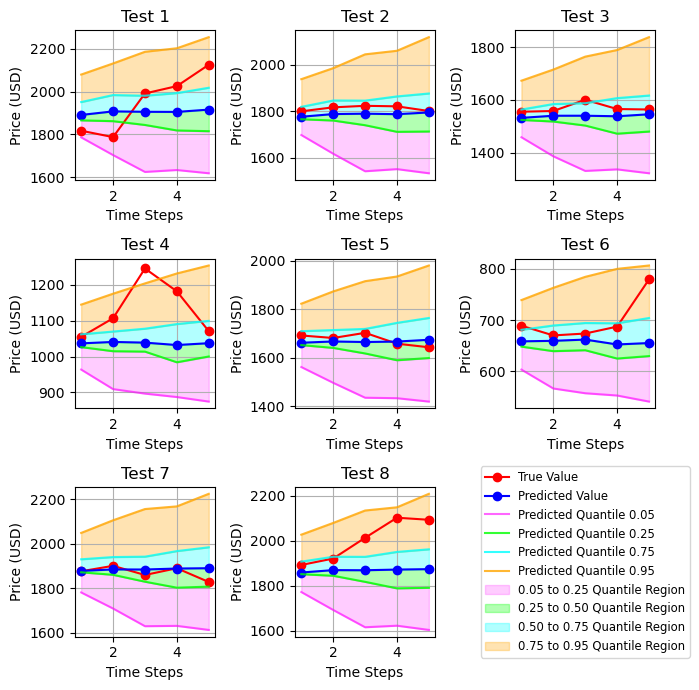

In [12]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(3, 3, figsize=(7, 7))
axs = axs.flatten()
for i in range(8):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='red', label='True Value')
    ax.plot(time_steps, predicted_050[i], marker='o', linestyle='-', color='blue', label='Predicted Value')
    
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='magenta', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='lime', label='Predicted Quantile 0.25', alpha=0.8)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='cyan', label='Predicted Quantile 0.75', alpha=0.8)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='orange', label='Predicted Quantile 0.95', alpha=0.8)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='magenta', alpha=0.2, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='lime', alpha=0.3, label='0.25 to 0.50 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='cyan', alpha=0.3, label='0.50 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='orange', alpha=0.3, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Test {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

handles, labels = axs[0].get_legend_handles_labels()

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=handles, labels=labels, loc='center', fontsize='small') 

plt.tight_layout()

if data == 'bitcoin':
    # compared to BTC-M-Linear, Horizon 1 prediction is clearly better here
    plt.savefig('results/bdlstm/multivariate/BTC-M-QBDLSTM.png')
else:
    plt.savefig('results/bdlstm/multivariate/ETH-M-QBDLSTM.png')

plt.show()
plt.close()